In [1117]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from category_encoders import BinaryEncoder

from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_validate

from sklearn.preprocessing import StandardScaler

In [1118]:
train = pd.read_csv(r"train.csv", index_col=False)
test = pd.read_csv(r"test.csv", index_col=False)
print("DF Size:" ,train.shape)
print("DF Size:" ,test.shape)
train.head(5)

DF Size: (8693, 14)
DF Size: (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [1119]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [1120]:
train.describe(include =['O'])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall
freq,1,4602,5439,8,5915,8291,2


In [1121]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [1122]:
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [1123]:
def fill_nan_with_frequencies(column):
    # Вычисляем частоты для каждого уникального значения в колонке
    frequencies = column.value_counts(normalize=True)
    
    # Создаем список значений для заполнения пропусков на основе частот
    values = frequencies.index
    probabilities = frequencies.values
    
    # Заменяем NaN случайными значениями на основе распределения частот
    nan_indices = column.isna()  # Получаем маску NaN
    
    # Используем np.random.choice для генерации значений по частотам
    fill_values = np.random.choice(values, size=nan_indices.sum(), p=probabilities)
    
    # Возвращаем колонку с заполненными значениями
    column.loc[nan_indices] = fill_values
    return column



PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.

CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side 
can be either P for Port or S for Starboard.

Destination - The planet the passenger will be debarking to.

Age - The age of the passenger.

VIP - Whether the passenger has paid for special VIP service during the voyage.

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

Name - The first and last names of the passenger.

Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [1124]:
def featureEngine(x, is_test = 0):
    ## Заполним нулевые значения с помощью частот, что позволит не терять данные, но и не создаст перевес к среднему значению, как еслиб заполняли средним значением.
    columns = x.columns
    for i in columns:
        if x[i].isnull().any():
            x[i] = fill_nan_with_frequencies(x[i].copy())

    ## Добавим пару параметров за счет разьединения прошлых, это положительно скажется на точности.
    x[['PassengerNumber', 'PassengerId']] = x['PassengerId'].astype(str).str.split("_", n=1, expand=True)
    x[['deck','numofcabinandside']] = x['Cabin'].astype(str).str.split("/", n=1, expand=True)
    x[['numofcabin','side']] = x['numofcabinandside'].astype(str).str.split("/", n=1, expand=True)

    ## Поменяем формат данных
    x['Age'] = x['Age'].astype(int)
    x['RoomService'] = x['RoomService'].astype(int)
    x['FoodCourt'] = x['FoodCourt'].astype(int)
    x['ShoppingMall'] = x['ShoppingMall'].astype(int)
    x['Spa'] = x['Spa'].astype(int)
    x['VRDeck'] = x['VRDeck'].astype(int)
    x['PassengerNumber'] = x['PassengerNumber'].astype(int)
    x['numofcabin'] = x['numofcabin'].astype(int)

    # Удалим лишнее
    x.drop(['numofcabinandside'], axis=1, inplace=True)
    x.drop(['PassengerId'], axis=1, inplace=True)
    x.drop(['Cabin'], axis=1, inplace=True)

    # Форматируем тип значений на булевы(был object так как были nan)
    x['VIP'] = x['VIP'].apply(lambda value: True if value == True else False)
    x['CryoSleep'] = x['CryoSleep'].apply(lambda value: True if value == True else False)
    if is_test == 0:
        x['Transported'] = x['Transported'].apply(lambda value: True if value == True else False)
    return x

In [1125]:
featureEngine(train)
featureEngine(test, is_test=True)
train.head(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerNumber,deck,numofcabin,side
0,Europa,False,TRAPPIST-1e,39,False,0,0,0,0,0,Maham Ofracculy,False,1,B,0,P
1,Earth,False,TRAPPIST-1e,24,False,109,9,25,549,44,Juanna Vines,True,2,F,0,S
2,Europa,False,TRAPPIST-1e,58,True,43,3576,0,6715,49,Altark Susent,False,3,A,0,S
3,Europa,False,TRAPPIST-1e,33,False,0,1283,371,3329,193,Solam Susent,False,3,A,0,S
4,Earth,False,TRAPPIST-1e,16,False,303,70,151,565,2,Willy Santantines,True,4,F,1,S


In [1126]:
test.head(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,PassengerNumber,deck,numofcabin,side
0,Earth,True,TRAPPIST-1e,27,False,0,0,0,0,0,Nelly Carsoning,13,G,3,S
1,Earth,False,TRAPPIST-1e,19,False,0,9,0,2823,0,Lerome Peckers,18,F,4,S
2,Europa,True,55 Cancri e,31,False,0,0,0,0,0,Sabih Unhearfus,19,C,0,S
3,Europa,False,TRAPPIST-1e,38,False,0,6652,0,181,585,Meratz Caltilter,21,C,1,S
4,Earth,False,TRAPPIST-1e,20,False,10,0,635,0,0,Brence Harperez,23,F,5,S


In [1127]:
new_order_train = ['PassengerNumber',
             'Name',
             'HomePlanet',
             'Destination',
             'deck',
             'numofcabin',
             'side',
             'Age',
             'CryoSleep',
             'VIP',
             'RoomService',
             'FoodCourt',
             'ShoppingMall',
             'Spa',
             'VRDeck',
             'Transported']  

new_order_test = ['PassengerNumber',
             'Name',
             'HomePlanet',
             'Destination',
             'deck',
             'numofcabin',
             'side',
             'Age',
             'CryoSleep',
             'VIP',
             'RoomService',
             'FoodCourt',
             'ShoppingMall',
             'Spa',
             'VRDeck']  

train = train.reindex(columns=new_order_train)
test = test.reindex(columns=new_order_test)
train.head(5)


,PassengerNumber,Name,HomePlanet,Destination,deck,numofcabin,side,Age,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,1,Maham Ofracculy,Europa,TRAPPIST-1e,B,0,P,39,False,False,0,0,0,0,0,False
1,2,Juanna Vines,Earth,TRAPPIST-1e,F,0,S,24,False,False,109,9,25,549,44,True
2,3,Altark Susent,Europa,TRAPPIST-1e,A,0,S,58,False,True,43,3576,0,6715,49,False
3,3,Solam Susent,Europa,TRAPPIST-1e,A,0,S,33,False,False,0,1283,371,3329,193,False
4,4,Willy Santantines,Earth,TRAPPIST-1e,F,1,S,16,False,False,303,70,151,565,2,True


In [1128]:
test.head(5)

,PassengerNumber,Name,HomePlanet,Destination,deck,numofcabin,side,Age,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,13,Nelly Carsoning,Earth,TRAPPIST-1e,G,3,S,27,True,False,0,0,0,0,0
1,18,Lerome Peckers,Earth,TRAPPIST-1e,F,4,S,19,False,False,0,9,0,2823,0
2,19,Sabih Unhearfus,Europa,55 Cancri e,C,0,S,31,True,False,0,0,0,0,0
3,21,Meratz Caltilter,Europa,TRAPPIST-1e,C,1,S,38,False,False,0,6652,0,181,585
4,23,Brence Harperez,Earth,TRAPPIST-1e,F,5,S,20,False,False,10,0,635,0,0


In [1129]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   PassengerNumber  8693 non-null   int64 
 1   Name             8693 non-null   object
 2   HomePlanet       8693 non-null   object
 3   Destination      8693 non-null   object
 4   deck             8693 non-null   object
 5   numofcabin       8693 non-null   int64 
 6   side             8693 non-null   object
 7   Age              8693 non-null   int64 
 8   CryoSleep        8693 non-null   bool  
 9   VIP              8693 non-null   bool  
 10  RoomService      8693 non-null   int64 
 11  FoodCourt        8693 non-null   int64 
 12  ShoppingMall     8693 non-null   int64 
 13  Spa              8693 non-null   int64 
 14  VRDeck           8693 non-null   int64 
 15  Transported      8693 non-null   bool  
dtypes: bool(3), int64(8), object(5)
memory usage: 908.5+ KB


In [1130]:
print(train['Destination'].unique())
train.describe(include=['O'])

['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e']


,Name,HomePlanet,Destination,deck,side
count,8693,8693,8693,8693,8693
unique,8473,3,3,8,2
top,Lestie Jacostaffey,Earth,TRAPPIST-1e,F,S
freq,3,4717,6040,2857,4389


In [1131]:
# Декодирование
def BinaryDecoder(encoded_df, original_df, encoder):
    decoded_df = pd.DataFrame()
    for col in encoder.cols:
        # Получаем количество бинарных столбцов для каждой переменной
        bin_cols = [c for c in encoded_df.columns if c.startswith(col)]
        # Получаем индексы уникальных комбинаций закодированных данных
        unique_binary_values = encoded_df[bin_cols].drop_duplicates().reset_index(drop=True)
        # Сопоставляем их с исходными значениями
        mapping = dict(zip(unique_binary_values.apply(tuple, axis=1), original_df[col].unique()))
        # Применяем декодирование
        decoded_df[col] = encoded_df[bin_cols].apply(lambda row: mapping[tuple(row)], axis=1)
    return decoded_df

In [1132]:
#le = LabelEncoder()
#for i in ['deck', 'Name','HomePlanet', 'Destination', 'side']:
#    train[i] = le.fit_transform(train[i])
#    train[i] = le.fit_transform(test[i])
#
#train.head(5)
#test.head(5)

# Сохраняем исходные данные
original_train = train.copy()
original_test = test.copy()
#т.к эти параметры содержат по 2-3 различных значения применим BinaryEncoder
encoder = BinaryEncoder(cols=['HomePlanet', 'Destination', 'side'])

train = encoder.fit_transform(train)
test = encoder.fit_transform(test)
#т.к эти параметры содержат много различных значения применим LabelEncoder
le = LabelEncoder()
for i in ['deck', 'Name']:
    train[i] = le.fit_transform(train[i])
    test[i] = le.fit_transform(test[i])

train.head(5)

,PassengerNumber,Name,HomePlanet_0,HomePlanet_1,Destination_0,Destination_1,deck,numofcabin,side_0,side_1,Age,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,1,5252,0,1,0,1,1,0,0,1,39,False,False,0,0,0,0,0,False
1,2,4502,1,0,0,1,5,0,1,0,24,False,False,109,9,25,549,44,True
2,3,457,0,1,0,1,0,0,1,0,58,False,True,43,3576,0,6715,49,False
3,3,7149,0,1,0,1,0,0,1,0,33,False,False,0,1283,371,3329,193,False
4,4,8319,1,0,0,1,5,1,1,0,16,False,False,303,70,151,565,2,True


In [1133]:
test.head(5)

,PassengerNumber,Name,HomePlanet_0,HomePlanet_1,Destination_0,Destination_1,deck,numofcabin,side_0,side_1,Age,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,13,2912,0,1,0,1,6,3,0,1,27,True,False,0,0,0,0,0
1,18,2406,0,1,0,1,5,4,0,1,19,False,False,0,9,0,2823,0
2,19,3376,1,0,1,0,2,0,0,1,31,True,False,0,0,0,0,0
3,21,2711,1,0,0,1,2,1,0,1,38,False,False,0,6652,0,181,585
4,23,668,0,1,0,1,5,5,0,1,20,False,False,10,0,635,0,0


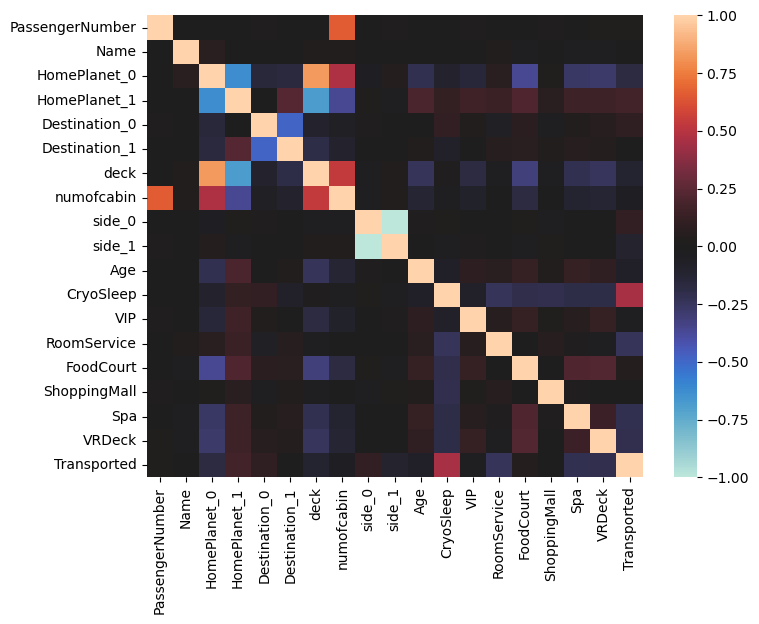

In [1134]:
corr = train.corr()
plt.figure(1, figsize=(8, 6)) 
sns.heatmap(corr,center=0) 
plt.show()
#train.corr()

## Как видно, номер кабины и пассажира имеет сильную корреляцию, это нормально т.к по условию номер пассажира зависит от номера кабины
## Также номер кабины сильно коррелирует с планетой отбытия
## Также есть сильная корреляция общей выживаемости и криосна в момент событий

In [1135]:
#sns.pairplot(original_train, plot_kws={'color': 'orange', 's': 200}, aspect=2)  
## aspect — the ratio of width to height
## s — size of the points
#plt.show()

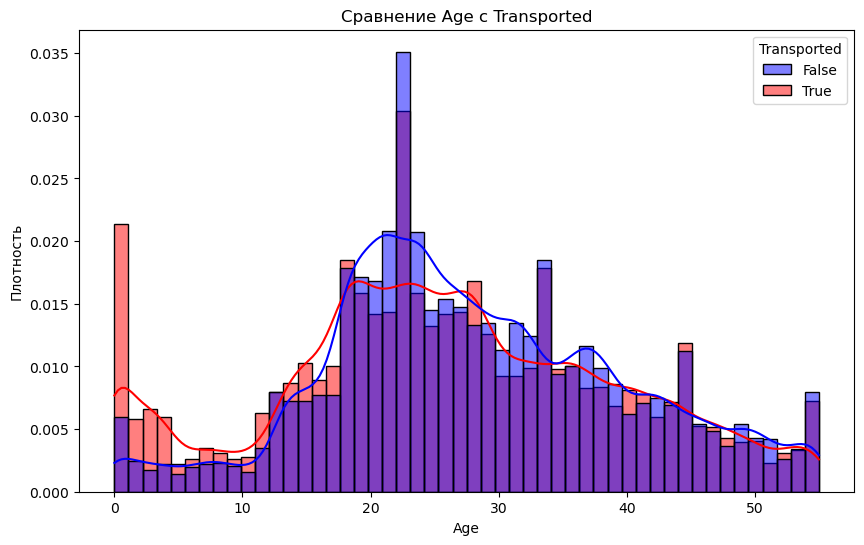

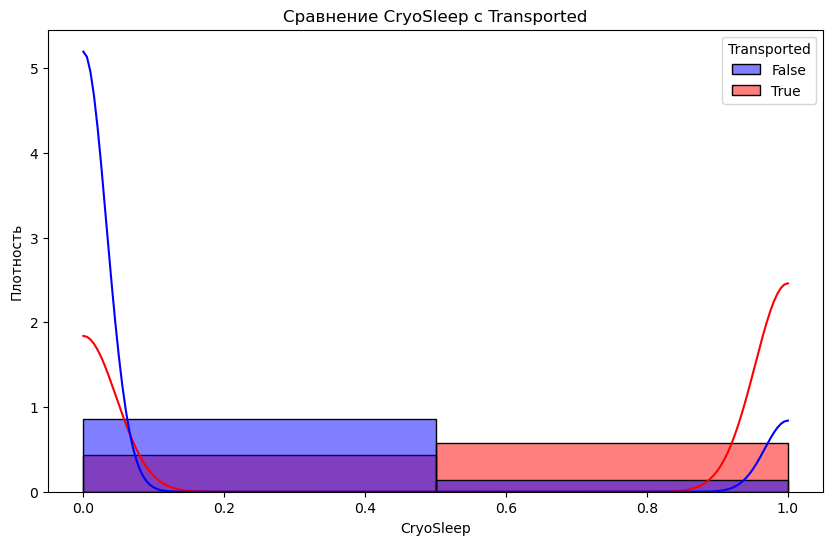

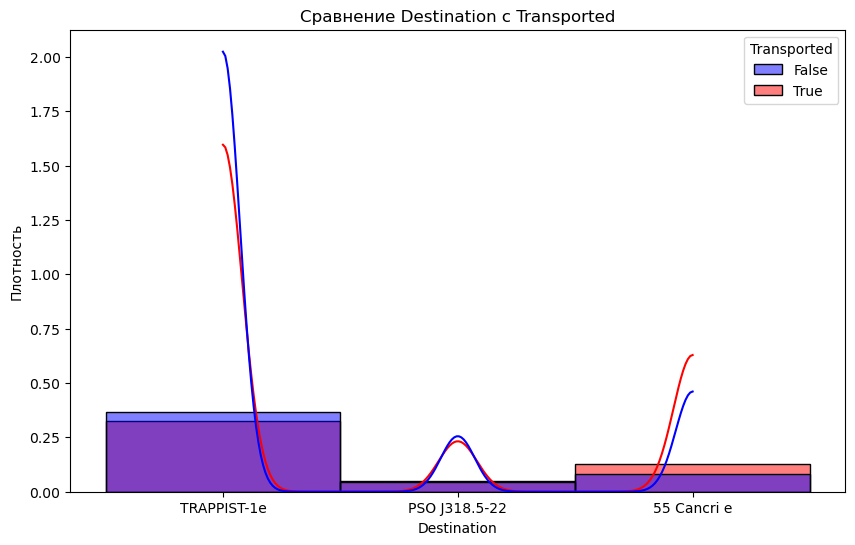

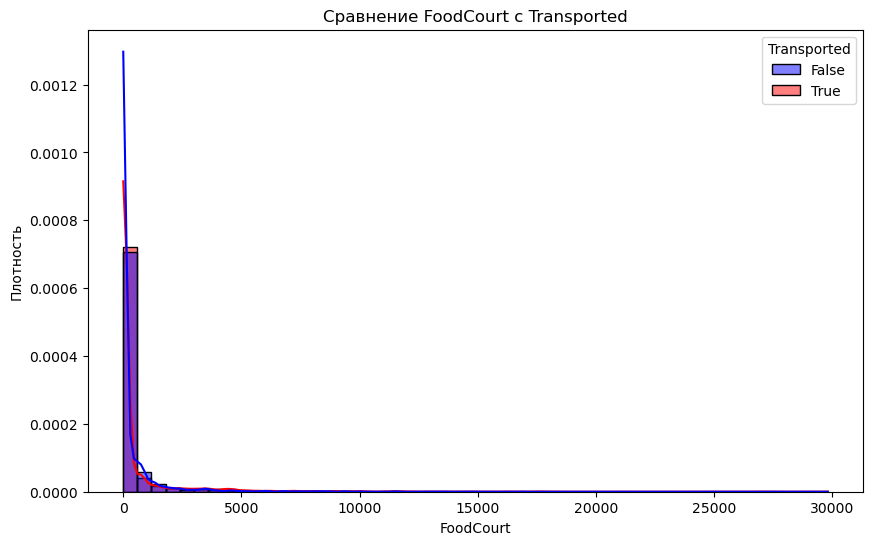

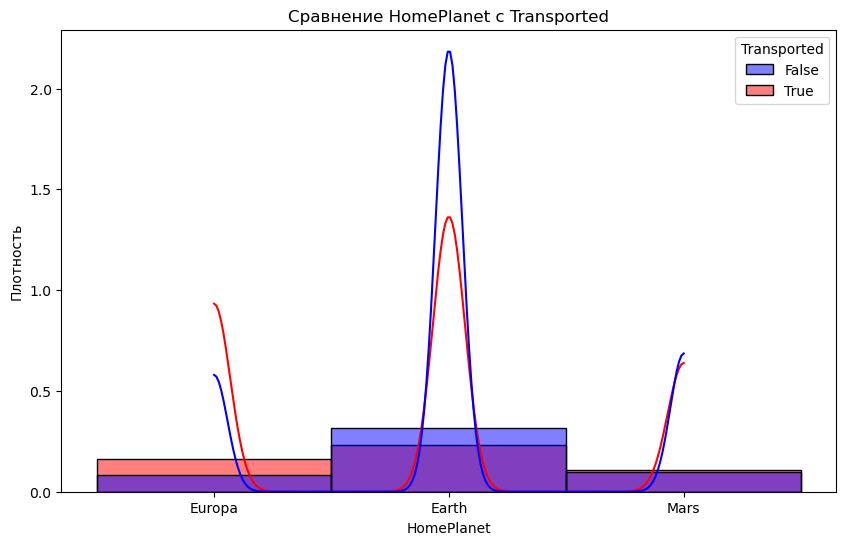

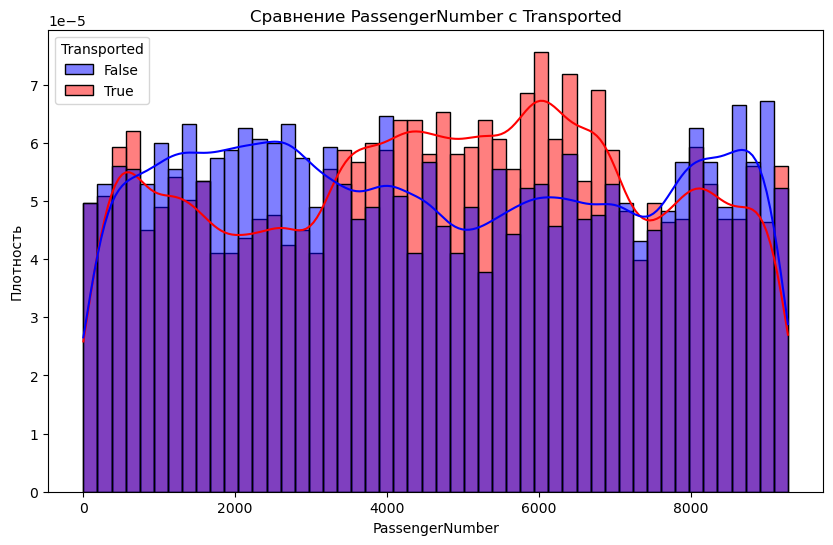

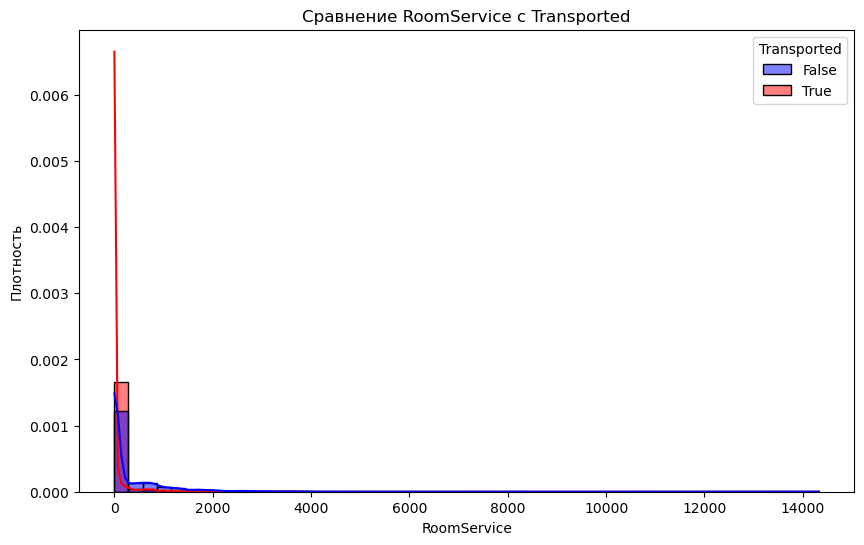

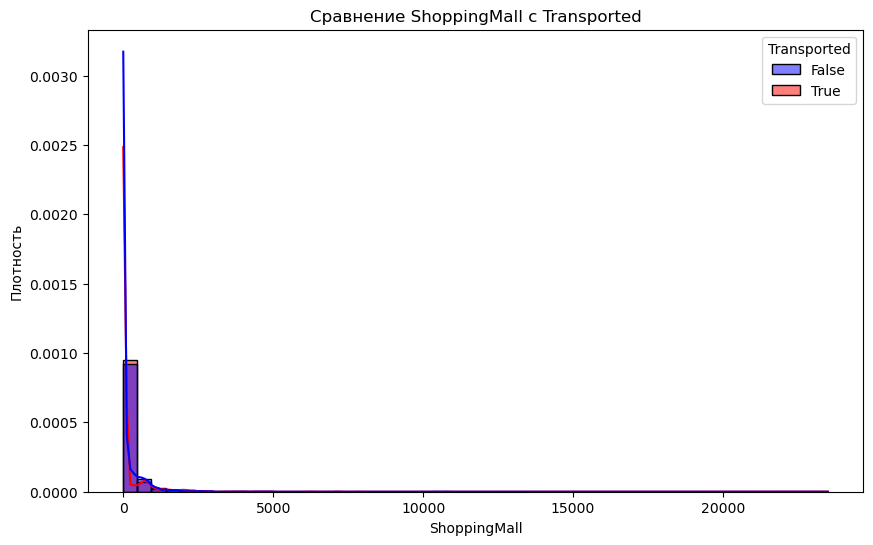

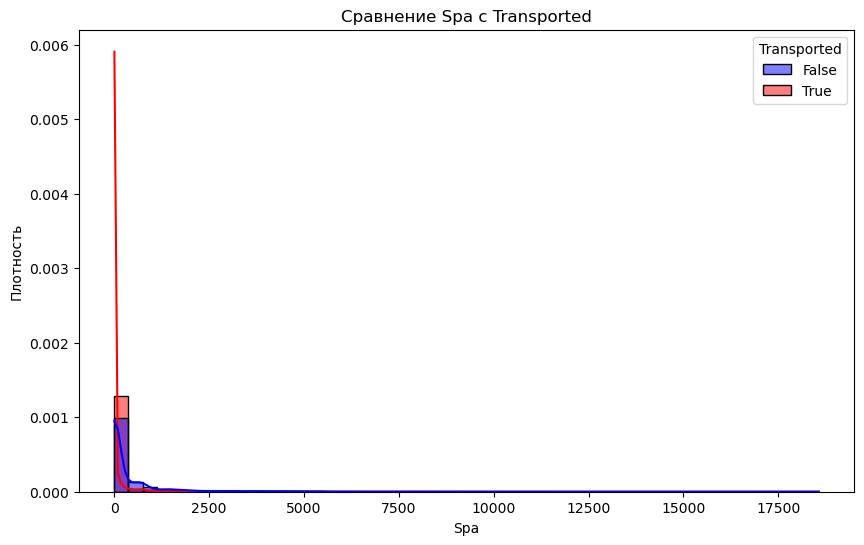

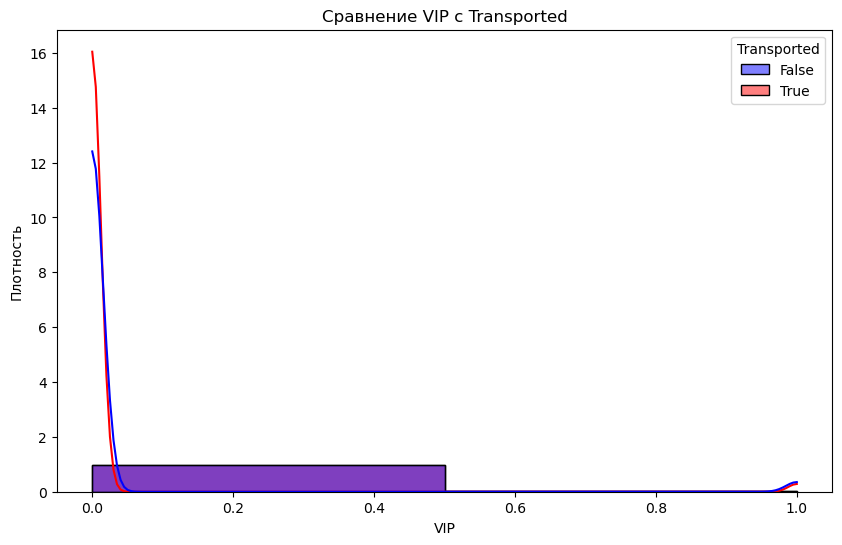

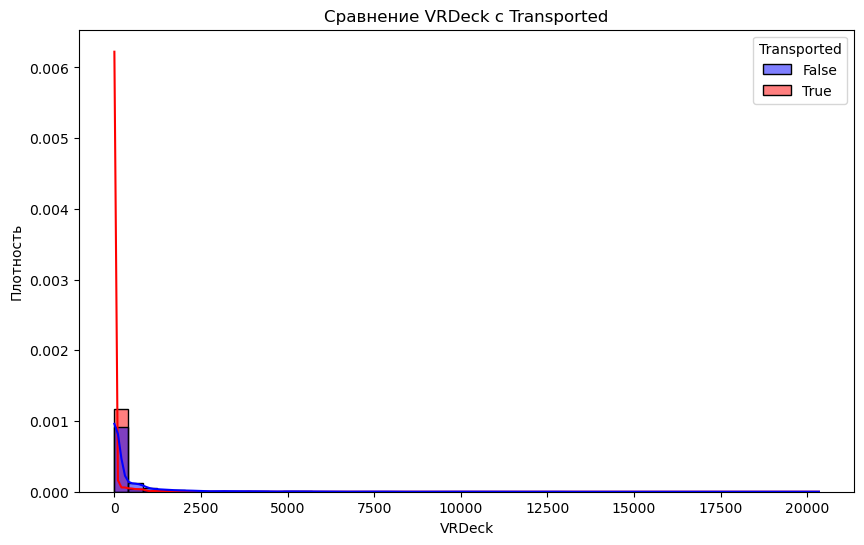

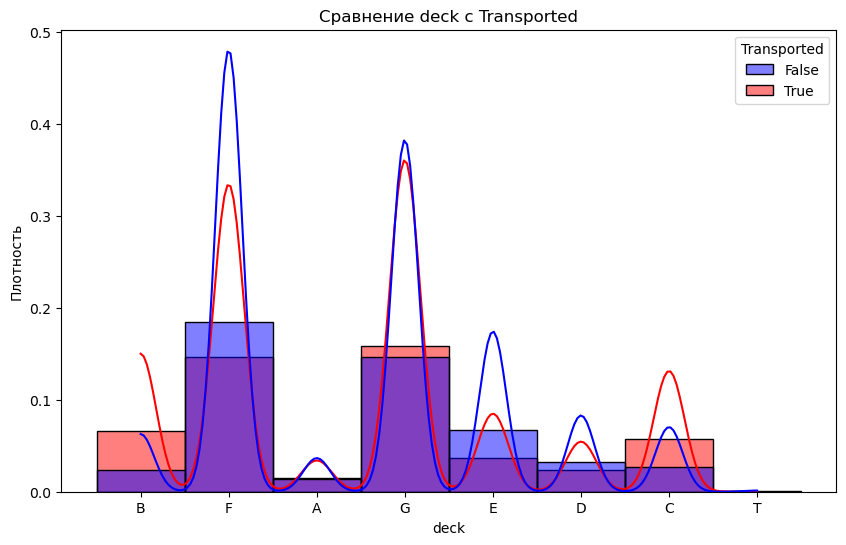

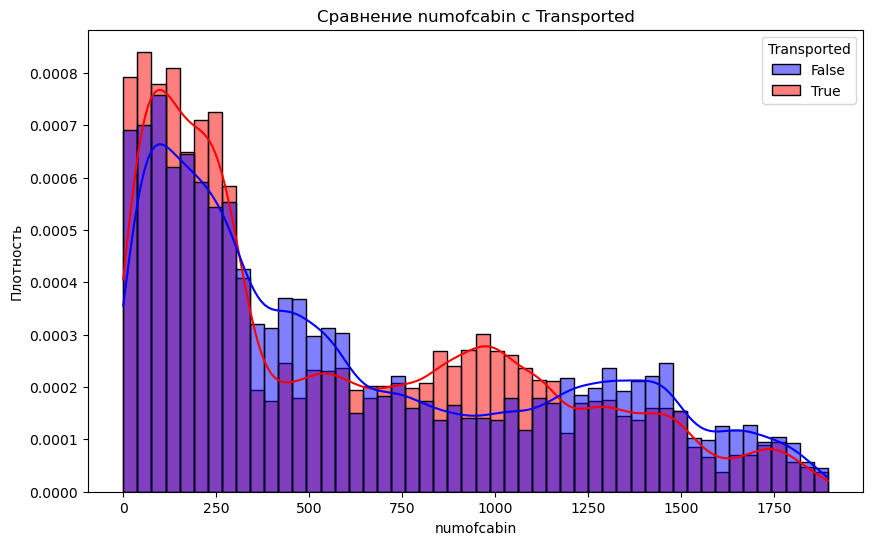

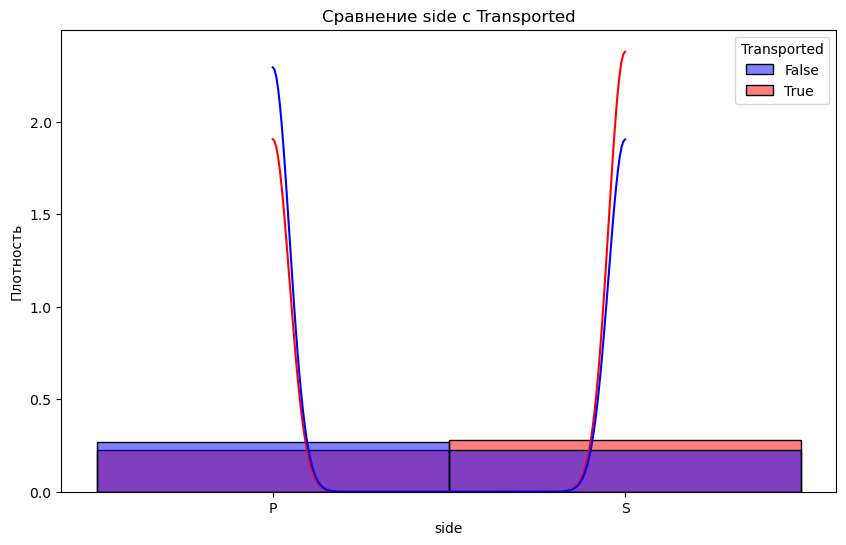

In [1139]:
columns_to_compare = original_train.columns.difference(['Transported', 'Name'])

# Создаем график для сравнения всех столбцов с выживаемостью
for column in columns_to_compare:
    plt.figure(figsize=(10, 6))
    
    num_bins = min(50, len(original_train[column].unique()))
    sns.histplot(data=original_train, x=column, hue='Transported', kde=True, 
                palette={False: 'blue', True: 'red'},
                kde_kws={'bw_adjust': 0.5}, stat='density', 
                alpha=0.5, bins=num_bins)
    plt.title(f'Сравнение {column} с Transported')
    plt.xlabel(column)
    plt.ylabel('Плотность')
    plt.show()

## Люди чаще выживали если были в криосне; если были молодыми; если ехали на 55 cancri e; если ехали с Европы; с номерами пассжиров 3800-7000;если не пользовались VRDeck; если были на палубе D, С; с номерами кабин 0-300 и 760-1100; и со стороны S.

In [ ]:
#Сделаем предсказание с помощью линейной регрессии
X_train = train.drop('Transported', axis=1)  
y_train = train['Transported']               

X_test = test

model = LinearRegression()

model.fit(X_train, y_train)
predictions = model.predict(X_test)
predictions = np.round(predictions)
predictions = predictions > 0

original_test['Transported'] = predictions
original_test.head(5)

,PassengerNumber,Name,HomePlanet,Destination,deck,numofcabin,side,Age,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,13,Nelly Carsoning,Earth,TRAPPIST-1e,G,3,S,27,True,False,0,0,0,0,0,True
1,18,Lerome Peckers,Earth,TRAPPIST-1e,F,4,S,19,False,False,0,9,0,2823,0,False
2,19,Sabih Unhearfus,Europa,55 Cancri e,C,0,S,31,True,False,0,0,0,0,0,True
3,21,Meratz Caltilter,Europa,TRAPPIST-1e,C,1,S,38,False,False,0,6652,0,181,585,False
4,23,Brence Harperez,Earth,TRAPPIST-1e,F,5,S,20,False,False,10,0,635,0,0,True
